# Implementation of a cascade of regressions for facial landmarks localisation
### Student : `Shubhamkumar PATEL` at M2 IMA

In [1]:
import skimage as skio
from skimage import io
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm 
from skimage.util import img_as_ubyte

## 1. Data Processing

In [2]:
# Root directory for provided train and test datasets
ROOT = "./300w/"
os.listdir(ROOT)

['300w_train_images.txt',
 '300w_train_landmarks.txt',
 'afw',
 'helen',
 'helen_testset.txt',
 'helen_testset_landmarks.txt',
 'ibug',
 'ibug.txt',
 'ibug_landmarks.txt',
 'lfpw',
 'lfpw_testset.txt',
 'lfpw_testset_landmarks.txt']

In [3]:
# Loading the names of each images to consider for training as provided in the 300w... text file
train_image_names = open(ROOT + '300w_train_images.txt', 'r').read().splitlines()
train_image_names[:10]

['helen/trainset/100032540_1.jpg',
 'helen/trainset/100040721_1.jpg',
 'helen/trainset/100040721_2.jpg',
 'helen/trainset/1002681492_1.jpg',
 'helen/trainset/1004467229_1.jpg',
 'helen/trainset/100466187_1.jpg',
 'helen/trainset/100591971_1.jpg',
 'helen/trainset/100843687_1.jpg',
 'helen/trainset/1010057391_1.jpg',
 'helen/trainset/1012675629_1.jpg']

## Data Augementation

In [14]:
from skimage.transform import resize

def resized_image_landmark(image, landmark):
    # Initializing useful values
    x, y = landmark[0], landmark[1]
    (width, height) = image.shape[:2]
    (xmin, xmax, ymin, ymax) = (int(min(x) - (0.15 * min(x))),
                                int(max(x) + (0.15 * max(x))),
                                int(min(y) - (0.15 * min(y))),
                                int(max(y) + (0.15 * max(y))))
            
    # Crop & Resize input image
    cropped_image = image[ymin:ymax, xmin:xmax]
    resized_image = resize(cropped_image, (128, 128))
    
    # Remap input Landmarks on the cropped + resized image
    x = (np.array(x) - xmin) / (xmax - xmin) * 128
    y = (np.array(y) - ymin) / (ymax - ymin) * 128
    return resized_image, [x, y]

def get_landmark(image_name):
    # Load landmark associated with image_name
    points = open(ROOT + image_name.split(".")[0] + ".pts").read().splitlines()
    xpoints, ypoints = [],[]
    for point in points:
        xpoints.append(float(point.split(" ")[0]))
        ypoints.append(float(point.split(" ")[1]))
    return [xpoints, ypoints]

In [18]:
# Create Train directory to save the new cropped and resized images for train
!mkdir train

In [20]:
# Create test directory to save the new cropped and resized images for test
!mkdir test

In [21]:
train_dir = "train"
train_images, train_landmarks = [], []

for img_id in tqdm(range(len(train_image_names))):
    # Loading image and its associated Landmark
    image_name = train_image_names[img_id]
    image = io.imread(ROOT + image_name)
    landmark = get_landmark(image_name)
    
    # Resizing the image and remapping the landmarks on the resized image
    resized_image, resized_landmark = resized_image_landmark(image, landmark)
    
    # Storing the resized train images and remapped landmarks in an array
    train_images.append(resized_image)
    train_landmarks.append(resized_landmark)
    
    # Saving the resized train images and remapped landmarks arrays in the train_dir directory 
    identifier = image_name.split(".")[0].split("/")[-1]
    skio.io.imsave(train_dir + "/" + identifier + ".png", img_as_ubyte(resized_image))
    np.save(train_dir + "/" + identifier + ".npy", resized_landmark)

100%|████████████████████████████████████████████████████████████████████████| 3148/3148 [06:48<00:00,  7.72it/s]


In [22]:
len(train_images), len(train_landmarks), int(len(os.listdir(train_dir)) / 2)

(3148, 3148, 3148)

In [23]:
train_landmarks = np.array(train_landmarks)
train_landmarks.shape

### Above we have the mean face computed from all the landmarks we had from our train set

### Now lets deal with the testset similarly to what we did for the trainset

In [27]:
testset_images_dirs = ["/helen/testset/", "/ibug/ibug/", "/lfpw/testset/"]
test_image_names = []
for img_dir in testset_images_dirs:
    for file in os.listdir(ROOT + img_dir):
        # Discard landmark files for now we only want the files that are images
        if ".pts" not in file:
            test_image_names.append(img_dir + file)

In [28]:
test_image_names[:10]

['/helen/testset/3017468498_1.jpg',
 '/helen/testset/3193845284_1.jpg',
 '/helen/testset/3260548295_1.jpg',
 '/helen/testset/3175828165_1.jpg',
 '/helen/testset/296814969_3.jpg',
 '/helen/testset/2978322154_1.jpg',
 '/helen/testset/3187824420_3.jpg',
 '/helen/testset/3035040633_1.jpg',
 '/helen/testset/308315761_3.jpg',
 '/helen/testset/3002247464_1.jpg']

In [29]:
test_dir = "test"
test_images, test_landmarks = [], []

for img_id in tqdm(range(len(test_image_names))):
    # Loading image and its associated Landmark
    image_name = test_image_names[img_id]
    image = skio.io.imread(ROOT + image_name)
    landmark = get_landmark(image_name)
    
    # Resizing the image and remapping the landmarks on the resized image
    resized_image, resized_landmark = resized_image_landmark(image, landmark)
    
    # Storing the resized test images and remapped landmarks in an array
    test_images.append(resized_image)
    test_landmarks.append(resized_landmark)
    
    # Saving the resized test images and remapped landmarks arrays in the test_dir directory 
    identifier = image_name.split(".")[0].split("/")[-1]
    skio.io.imsave(test_dir + "/" + identifier + ".png", img_as_ubyte(resized_image))
    np.save(test_dir + "/" + identifier + ".npy", resized_landmark)

100%|██████████████████████████████████████████████████████████████████████████| 689/689 [01:17<00:00,  8.94it/s]


In [30]:
len(test_images), len(test_landmarks), int(len(os.listdir(test_dir)) / 2)

(689, 689, 689)

### Load saved image and landmarks from train directory (or we can reuse the ones computed above)

In [4]:
landmarks = np.array([np.load("train/" + i) for i in os.listdir("train") if i.endswith('.npy')])
landmarks.shape

(3148, 2, 68)

In [5]:
np.save("landmarks.npy", landmarks)

In [6]:
images = [skio.io.imread("train/" + i) for i in os.listdir("train") if i.endswith('.png')]
len(images)

3148

### Computing the Mean Landmark from all the computed landmarks from the trainset

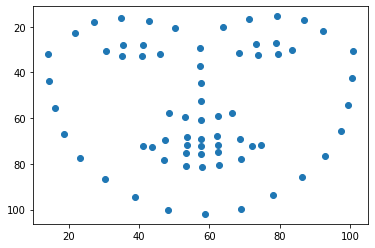

In [7]:
mean_landmark = landmarks.mean(axis=0)
plt.gca().invert_yaxis()
plt.scatter(mean_landmark[0], mean_landmark[1])
plt.show()

## Adding Perturbations to the train landmarks

#### The perturbations or transformations can be rather geometric transformation and photometric transformation. Geometric transformation maps pixel values of an image to new positions to change the geometry of an image (distortions, rotation, shifting, scaling, cropping, flipping, etc) and Photometric transformation changes the RGB channels by modfying the pixel colors.

#### We are doing this in order to have a more robust model, by having more data on the faces we can train our model efficiently by applying these data augmentation method.

#### To estimate these perturbations we can either train a supervised/unsupervised Deep Neural Network or we can estimates the perturbations directly by using the landmarks extracted from the images and comparing them to a base model/landmarks (like our mean face shape above) or a 3D reconstructed face model which we can use to estimated any distortions from a base 3D face model.

#### Useful functions to apply random tranformations on the computed mean landmark

In [8]:
def scale(landmark, scale):
    x, y = landmark
    xy_center = ((min(x) + max(x)) * .5, (min(y) + max(y)) * .5)
    delta_x, delta_y = xy_center[0] - x, xy_center[1] - y
    x_scale = xy_center[0] - scale * delta_x
    y_scale = xy_center[1] - scale * delta_y
    return np.array([x_scale, y_scale])

def translate(landmark, u):
    return np.add(ld.T, translation).T

In [9]:
# Replicated 10 times the landmarks associated with an image and apply random perturbations on each of them
pert_ldmrks = []
for ld in landmarks:
    ld_10_perturbations = ld.repeat(10, axis=0).reshape((10,68,2))
    for i in range(10):
        # Translation vector with values in between -20px and 20px
        translation = np.random.uniform(low=-20, high=20)
        # Scale factor with values in between 0.8 and 1.2 (+-20% of 1.0)
        scale_val = np.random.uniform(low=0.8, high=1.2)
        ld_10_perturbations[i] = scale(translate(ld_10_perturbations[i], translation), scale_val).T
        #ld_10_perturbations[i] = scale(translate(mean_landmark, translation), scale_val).T
    pert_ldmrks.append(ld_10_perturbations)
pert_ldmrks = np.array(pert_ldmrks)
pert_ldmrks.shape, landmarks.shape

((3148, 10, 68, 2), (3148, 2, 68))

In [10]:
pert_ldmrks = pert_ldmrks.reshape((pert_ldmrks.shape[0] * pert_ldmrks.shape[1], pert_ldmrks.shape[2], pert_ldmrks.shape[3]))
pert_ldmrks.shape

(31480, 68, 2)

In [11]:
np.save("pert_ldmrks.npy", pert_ldmrks)

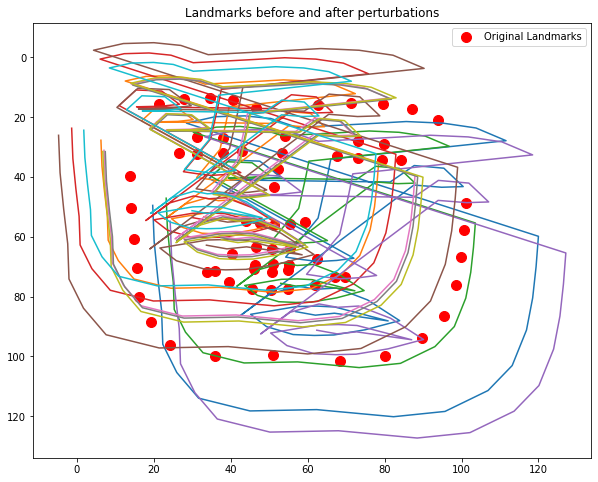

In [12]:
plt.figure(figsize=(10,8))
for i in range(0,10):
    x, y = pert_ldmrks[i].T
    plt.plot(x,y)
xg, yg = landmarks[0]
plt.title("Landmarks before and after perturbations")
plt.scatter(xg,yg, s=100, color="r", label="Original Landmarks")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

As we can see above we took one face centered in the (128, 128) frame and we applied random perturbations like translation of +-20px and scale of +-20%, and we got 10 different results of faces as plotted above.

## 2. Training of a single regressor

### 2.1 Feature extraction

#### We don't directly use the raw values of the image pixels as a representation because it would lead to heavy computation and we would require a lot of parameters to extract the features from the faces. Here by reducting a SIFT representations of the data we encoded the information on low dimension vectors so that we can perform more in depth analysis upon them without fearing for the computional requirements.

In [13]:
def sift_descriptor(image, landmark):
    keypoints = [cv2.KeyPoint(x, y, 20) for x,y in landmark]
    sift = cv2.SIFT_create()
    _, desc = sift.compute(image, keypoints)
    return desc.reshape(desc.shape[0] * desc.shape[1])

In [14]:
from sklearn.decomposition import PCA

sifts = []
for img_id in tqdm(range(len(images))):
    image = images[img_id]
    for i in range(10):
        landmark = pert_ldmrks[img_id + i]
        sifts.append(sift_descriptor(image, landmark))
sifts = np.array(sifts)
sifts.shape

100%|██████████████████████████████████████████████████████████████████████████████| 3148/3148 [06:16<00:00,  8.37it/s]


(31480, 8704)

In [16]:
# Optionally we can save to sifts in order to reload it without having to recompute them but this might take a lot of space especially for the train set :/
np.save("sifts.npy", sifts)

**After concatenating all the features from all 10 landmarks we had for each features we get a feature vector of dimension `(10 Landmarks * Number of Images, Size of SIFT Feature)` which in our case is : `(31480, 8704)`**

So each features is of size `8704` for each image associated to all of the `3148 x 10 Perturbations = 31480` elements we are dealing with here.

### 2.2 Dimensionality reduction

#### If we have a large number of dimensions in the feature space that means that the volume of that space is very large but the points we require might only represent a small portion of the entire space therefore by performing a dimensionality reduction we are able to keep only the relevant information on the underlying features space from the original one. 

In [17]:
from sklearn.decomposition import PCA
#sifts = np.load("sifts.npy")
pca = PCA(0.98)
X = pca.fit(sifts)
X = pca.transform(sifts)

In [18]:
X.shape # Shape of the Resulting Matrix XTilde

(31480, 1033)

#### So the Shape of the new resulting matrix $\tilde{X_0}$ is `(31480, 1033)`

In [19]:
A0 = pca.components_
A0.shape

(1033, 8704)

In [20]:
#np.save("XTrain.npy", X)

### 2.3 Displacement estimation

In [21]:
# Adding extra zeros to the X vector
Xtilde = np.column_stack((X, np.ones(X.shape[0])))
Xtilde.shape

(31480, 1034)

In [61]:
# Least Square Estimation
from sklearn.linear_model import LinearRegression

#pert_ldmrks = np.load("pert_ldmrks.npy")
y_pert = pert_ldmrks.reshape((pert_ldmrks.shape[0], pert_ldmrks.shape[1] * pert_ldmrks.shape[2]))
y = np.repeat(landmarks, 10, axis=0)
y = y.reshape(y.shape[0], y.shape[1] * y.shape[2])

In [62]:
reg = LinearRegression().fit(Xtilde, y)

In [63]:
reg.score(Xtilde, y)

0.5669642605707478

In [64]:
reg.coef_

array([[-4.03587827e-05,  3.43740751e-03,  6.73683451e-03, ...,
         8.87721036e-03,  8.51131117e-03,  0.00000000e+00],
       [-1.28682227e-04,  3.34791221e-03,  6.69305300e-03, ...,
         7.10154066e-03,  8.43321429e-03,  0.00000000e+00],
       [-1.91557989e-04,  3.09871382e-03,  6.61441332e-03, ...,
         4.88449348e-03,  9.03818151e-03,  0.00000000e+00],
       ...,
       [-2.50382197e-05, -3.14236292e-04, -1.18890267e-04, ...,
        -1.67206053e-03, -2.55572746e-03,  0.00000000e+00],
       [-5.26927342e-05, -4.28796019e-04, -1.68624442e-04, ...,
        -2.82252286e-03, -1.52088635e-03,  0.00000000e+00],
       [-8.85888014e-05, -4.79632831e-04, -1.50420477e-04, ...,
        -3.00599389e-03, -8.62576942e-04,  0.00000000e+00]])

In [65]:
delta_s = reg.predict(Xtilde)
delta_s

array([[14.53408038, 14.00829997, 13.78776788, ..., 72.91057079,
        73.01218375, 72.46903787],
       [16.83615982, 15.6984736 , 15.09359   , ..., 73.78179197,
        74.00500174, 73.61737925],
       [16.04790037, 14.35539962, 13.15598759, ..., 72.51343791,
        72.30070513, 71.79804475],
       ...,
       [10.40619864, 12.90559922, 16.34382135, ..., 73.58340311,
        75.04346144, 74.99293455],
       [ 9.94234585, 13.15233435, 17.51483967, ..., 73.6136548 ,
        75.30303399, 75.45064787],
       [ 8.39170607, 11.40471197, 15.45905312, ..., 74.11992565,
        75.84852733, 75.97071053]])

In [66]:
from sklearn.metrics import mean_absolute_error

In [67]:
# Computing the MAE with the prediction obtained previously and the Ground truth for our Trainset
mean_absolute_error(delta_s, y)

3.851782819362423

In [68]:
# Recreating a ground truth for comparison purposes
ytrain = np.repeat(landmarks, 10, axis=0)
ytrain.shape

(31480, 2, 68)

In [69]:
delta_s.reshape((31480, 2, 68))

array([[[14.53408038, 14.00829997, 13.78776788, ..., 57.57319637,
         52.70101077, 48.24818197],
        [37.6717352 , 49.18551881, 61.2953853 , ..., 72.91057079,
         73.01218375, 72.46903787]],

       [[16.83615982, 15.6984736 , 15.09359   , ..., 61.14740212,
         56.31511925, 51.9773982 ],
        [39.54474104, 50.26384034, 61.62506028, ..., 73.78179197,
         74.00500174, 73.61737925]],

       [[16.04790037, 14.35539962, 13.15598759, ..., 57.56859242,
         52.03516619, 47.16701184],
        [37.18951939, 47.91325319, 59.3455309 , ..., 72.51343791,
         72.30070513, 71.79804475]],

       ...,

       [[10.40619864, 12.90559922, 16.34382135, ..., 64.18878976,
         58.13219612, 52.55619628],
        [32.68057904, 44.56427363, 55.76893894, ..., 73.58340311,
         75.04346144, 74.99293455]],

       [[ 9.94234585, 13.15233435, 17.51483967, ..., 64.48737161,
         58.51138744, 53.17393867],
        [37.28101539, 49.97379868, 61.78101756, ..., 73.61365

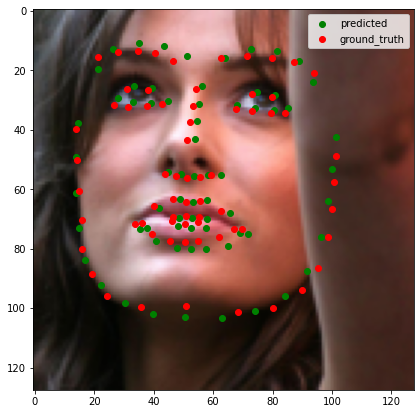

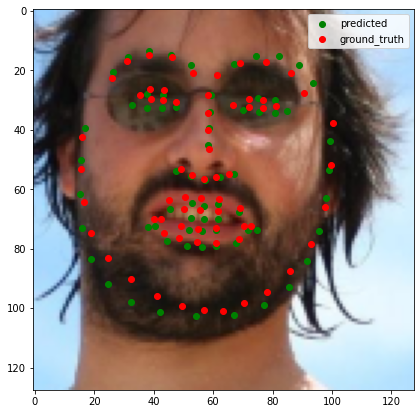

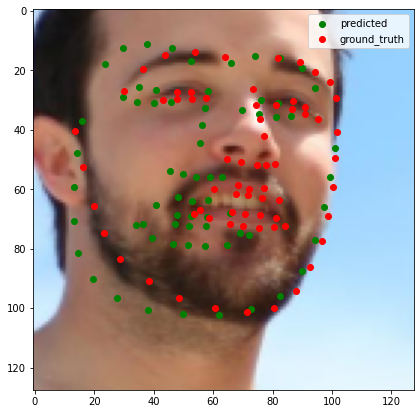

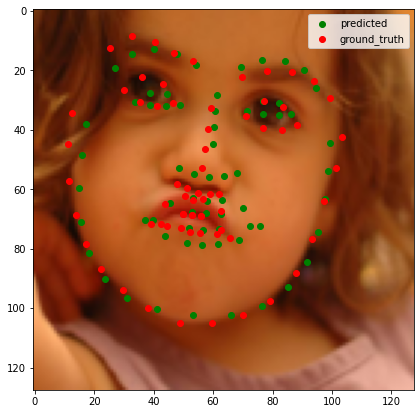

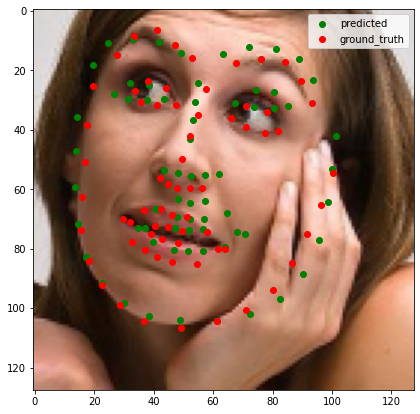

In [82]:
# Displaying the predicted values with the ground truth for comparison

for ind in range(5):
    x,y = delta_s[ind].reshape((2, 68))
    lx, ly = landmarks[ind]
    plt.figure(figsize=(7,7))
    plt.scatter(x,y, label="predicted", color="green")
    plt.scatter(lx,ly, label="ground_truth", color="red")
    plt.imshow(images[ind])
    plt.legend()

### For test set use the pca transform to project the data into the same space used in the train set then refuse the LinearRegressor `reg` to get the predict some displacement result and compare them with the ground truth.

In [71]:
test_landmarks = np.array([np.load("test/" + i) for i in os.listdir("test") if i.endswith('.npy')])
test_landmarks.shape

(689, 2, 68)

In [72]:
np.save("test_landmarks.npy", landmarks)

In [73]:
test_images = [skio.io.imread("test/" + i) for i in os.listdir("test") if i.endswith('.png')]
len(test_images)

689

In [74]:
testsifts = []
for img_id in tqdm(range(len(test_images))):
    image = test_images[img_id]
    landmark = test_landmarks[img_id].T
    testsifts.append(sift_descriptor(image, landmark))
testsifts = np.array(testsifts)
testsifts.shape

100%|████████████████████████████████████████████████████████████████████████████████| 689/689 [00:08<00:00, 81.76it/s]


(689, 8704)

In [75]:
Xtest = pca.transform(testsifts)
Xtest.shape

(689, 1033)

In [76]:
Xtest_tilde = np.column_stack((Xtest, np.ones(Xtest.shape[0])))
Xtest_tilde.shape

(689, 1034)

In [77]:
ytest = test_landmarks.copy()
ytest = ytest.reshape(ytest.shape[0], ytest.shape[1] * ytest.shape[2])
reg.score(Xtest_tilde, ytest)

0.450469358078729

In [78]:
# Evalute the prediction of the regressor on our TestSet
delta_s_test = reg.predict(Xtest_tilde)
delta_s_test.shape

(689, 136)

In [79]:
# Computing the MAE with the prediction obtained previously and the Ground truth for our TestSet
mean_absolute_error(delta_s_test, ytest)

4.259766610163501

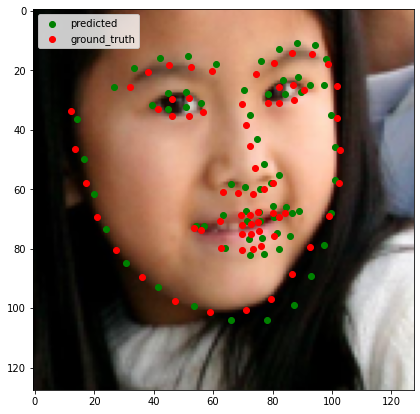

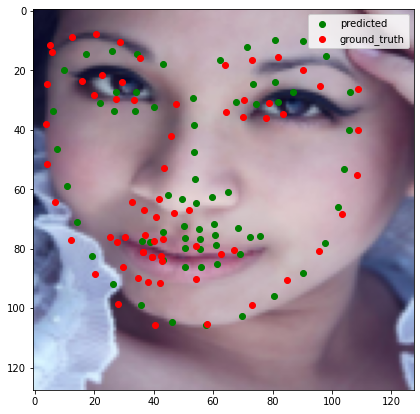

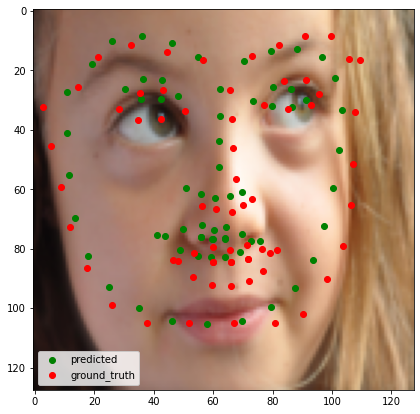

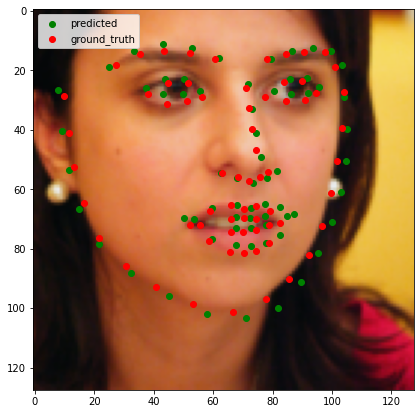

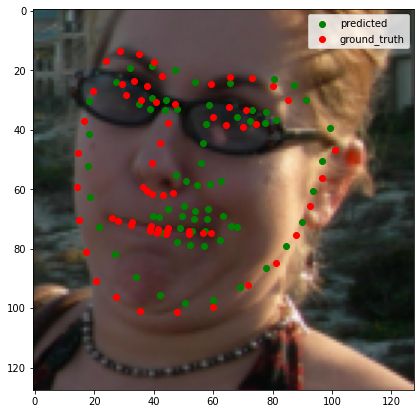

In [81]:
# Displaying the predicted values with the ground truth for comparison

for ind in range(5):
    xt,yt = delta_s_test[ind].reshape((2, 68))
    lxt, lyt = test_landmarks[ind]
    plt.figure(figsize=(7,7))
    plt.scatter(xt,yt, label="predicted", color="green")
    plt.scatter(lxt,lyt, label="ground_truth", color="red")
    plt.imshow(test_images[ind])
    plt.legend()
    plt.show()

### The prediction errors computed above are not relevant to evaluate our methods because we are using a Mean Average Error which measures the average magnitude of the errors in a set of predictions, without considering their direction which might come in handy if we need to optimize our model by handling that "direction" diffrently.

### We can see that the predictions or the displacement we computed gives results that are close to the ground truth. Even if we haven't converged to the optimal solution yet, we are able to get conclusive results judging by the plots above as well as the MAE or Mean Absolute Error where we got 3.851 for the trainset and 4.25 for the testset, we can say that we were able to estimate a somewhat accurate displacement on both our train and test set. We might require a better data augmentation perhaps in the perturbations we introduced we might want to add rotations, horizontal and vertical flips, distortions, and others things that will give us a robust model which can easily converge towards the optimal positions of landmarks.